# FINETUNING FOR CLASSIFICATION

### DOWNLOADING DATASET

In [2]:
import urllib.request
import ssl
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exist. Skipping download and extraction.")
        return

    # Create an unverified SSL context
    ssl_context = ssl._create_unverified_context()

    # Downloading the file 
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File download and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection\SMSSpamCollection.tsv already exist. Skipping download and extraction.


<div class="alert alert-block alert-info">

After executing the preceding code, the dataset is saved as a tab-separated text file,
SMSSpamCollection.tsv, in the sms_spam_collection folder. 

We can load it into a pandas
DataFrame as follows:
</div>

In [3]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


<div class="alert alert-block alert-success">

When we check the class distribution, we see that the data contains "ham" (i.e., "not spam") much more frequently than "spam"
    
</div>

In [4]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


<div class="alert alert-block alert-info">

For simplicity, and because we prefer a small dataset for understanding purposes anyway (it will make it possible to finetune the LLM faster), we subsample (undersample) the dataset so that it contains 747 instances from each class
</div>

In [5]:
def create_balanced_dataset(df):
    
    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]
    
    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    
    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


<div class="alert alert-block alert-info">

After executing the previous code to balance the dataset, we can see that we now have
equal amounts of spam and non-spam messages:

</div>

<div class="alert alert-block alert-success">

Next, we convert the "string" class labels "ham" and "spam" into integer class labels 0 and
1, respectively:
    
</div>

In [6]:
balanced_df["Label"] = balanced_df["Label"].map({"ham":0, "spam":1})

<div class="alert alert-block alert-info">

This process is similar to converting text into token IDs. 

However, instead of using the GPT
vocabulary, which consists of more than 50,000 words, we are dealing with just two token
IDs: 0 and 1.

</div>

<div class="alert alert-block alert-success">

We create a random_split function to split the dataset into three parts: 70% for
training, 10% for validation, and 20% for testing. 

(These ratios are common in machine
learning to train, adjust, and evaluate models.)    
</div>

In [7]:
def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# Test size is implied to be 0.2 as the remainder

In [8]:
print(len(train_df))
print(len(validation_df))
print(len(test_df))

1045
149
300


<div class="alert alert-block alert-success">

Additionally, we save the dataset as CSV (comma-separated value) files, which we can
reuse later:
</div>

In [9]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

### CREATING DATALOADERS

<div class="alert alert-block alert-success">

Previously, we utilized a sliding window technique to generate uniformly
sized text chunks, which were then grouped into batches for more efficient model training.
Each chunk functioned as an individual training instance

In the case of email spam classification, have two primary options:

(1) Truncate all messages to the length of the shortest message in the
dataset or batch.

(2) Pad all messages to the length of the longest message in the dataset or
batch.
    
</div>

<div class="alert alert-block alert-warning">

Option 1 is computationally cheaper, but it may result in significant information loss if
shorter messages are much smaller than the average or longest messages, potentially
reducing model performance. 

So, we opt for the second option, which preserves the entire
content of all messages.

To implement option 2, where all messages are padded to the length of the longest
message in the dataset, we add padding tokens to all shorter messages. 

For this purpose,
we use "<|endoftext|>" as a padding token.

    
However, instead of appending the string "<|endoftext|>" to each of the text messages
directly, we can add the token ID corresponding to "<|endoftext|>" to the encoded text
</div>

<div class="alert alert-block alert-success">

As we have seen earlier, we first need to implement a PyTorch Dataset, which
specifies how the data is loaded and processed, before we can instantiate the data loaders.
    
</div>

<div class="alert alert-block alert-success">

For this purpose, we define the SpamDataset class.

This SpamDataset class handles several key tasks: it identifies the
longest sequence in the training dataset, encodes the text messages, and ensures that all
other sequences are padded with a padding token to match the length of the longest
sequence.
    
</div>

In [10]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

<div class="alert alert-block alert-info">

Step 1: Pre-tokenize texts
    
Step 2: Truncate sequences if they are longer than max_length
    
Step 3: Pad sequences to the longest sequence

</div>

<div class="alert alert-block alert-warning">

The SpamDataset class loads data from the CSV files we created earlier, tokenizes the text
using the GPT-2 tokenizer from tiktoken and allows us to pad or truncate the sequences to
a uniform length determined by either the longest sequence or a predefined maximum
length.
</div>

<div class="alert alert-block alert-success">

This ensures each input tensor is of the same size, which is necessary to create the
batches in the training data loader we implement next:
    
</div>

In [11]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None, 
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


<div class="alert alert-block alert-info">

The code outputs 120, showing that the longest sequence contains no more than 120
tokens, a common length for text messages. 
                       
It's worth noting that the model can handle
sequences of up to 1,024 tokens, given its context length limit. 

If your dataset includes
longer texts, you can pass max_length=1024 when creating the training dataset in the
preceding code to ensure that the data does not exceed the model's supported input
(context) length.

</div>

<div class="alert alert-block alert-success">

Next, we pad the validation and test sets to match the length of the longest training
sequence. 

It's important to note that any validation and test set samples exceeding the
length of the longest training example are truncated using
encoded_text[:self.max_length] in the SpamDataset code we defined earlier. 

This
truncation is optional; you could also set max_length=None for both validation and test
sets, provided there are no sequences exceeding 1,024 tokens in these sets
</div>

In [12]:
val_dataset = SpamDataset(
    csv_file="validation.csv", 
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

<div class="alert alert-block alert-success">

Using the datasets as inputs, we can instantiate the data loaders similarly to what we did earlier. 

However, in this case, the targets represent class labels rather than the next
tokens in the text. 

For instance, choosing a batch size of 8, each batch will consist of 8
training examples of length 120 and the corresponding class label of each example.
</div>

In [13]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

<div class="alert alert-block alert-success">

To ensure that the data loaders are working and are indeed returning batches of the
expected size, we iterate over the training loader and then print the tensor dimensions of
the last batch:

</div>

In [14]:
print("Train loader:-")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:-", input_batch.shape)
print("Label batch dimensions:-", target_batch.shape)

Train loader:-
Input batch dimensions:- torch.Size([8, 120])
Label batch dimensions:- torch.Size([8])


<div class="alert alert-block alert-info">

As we can see, the input batches consist of 8 training examples with 120 tokens each, as
expected.

The label tensor stores the class labels corresponding to the 8 training examples.

</div>

<div class="alert alert-block alert-success">

Lastly, to get an idea of the dataset size, let's print the total number of batches in each
dataset:
</div>

In [15]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


<div class="alert alert-block alert-success">

This concludes the data preparation. Next, we will prepare the model for
finetuning.
</div>

## INITIALIZING A MODEL WITH PRETRAINED WEIGHTS

<div class="alert alert-block alert-success">

In this section, we prepare the model we will use for the classification-finetuning to identify
spam messages. 

We start with initializing the pretrained model we worked with previously
</div>

In [16]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0, # Dropout rate
    "qkv_bias": True, # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model context"
    f"length {BASE_CONFIG['context_length']}. Reinitialize dataset with "
    f"max_length={BASE_CONFIG['context_length']}"
)

<div class="alert alert-block alert-success">

Next, we import the download_and_load_gpt function from the gpt_download3.py file we
downloaded earlier. 

Furthermore, we also reuse the GPTModel class and
load_weights_into_gpt function from earlier section to load the downloaded weights into the
GPT model:

</div>

### The dependend codes to run the code of this section from GPT-Model.ipynb

In [17]:
import torch
import torch.nn as nn

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5* x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x,3))
        ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), # Expansion 
            GELU(), # Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), # Contraction 
        )

    def forward(self, x):
        return self.layers(x)
    
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec
    
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x
    
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))
    
import numpy as np 

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

### Main code of this section 

In [19]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

from gpt_download3 import download_and_load_gpt2

settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

C:\Users\praja\AppData\Roaming\Python\Python313\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\checkpoint


C:\Users\praja\AppData\Roaming\Python\Python313\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\encoder.json


C:\Users\praja\AppData\Roaming\Python\Python313\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\hparams.json


C:\Users\praja\AppData\Roaming\Python\Python313\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001


C:\Users\praja\AppData\Roaming\Python\Python313\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.index


C:\Users\praja\AppData\Roaming\Python\Python313\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.meta


C:\Users\praja\AppData\Roaming\Python\Python313\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\vocab.bpe


<div class="alert alert-block alert-success">

To ensure that the model was loaded correctly, let's double-check that it generates coherent text
</div>

### The dependend codes to run the code of this section from GPT-Model.ipynb

In [21]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you forward.

The first step is to understand


### Main code of this section

In [22]:
text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


<div class="alert alert-block alert-success">

Now, before we start finetuning the model as a spam classifier, let's see if the model can
perhaps already classify spam messages by prompting it with instructions:
    
</div>

In [23]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23, 
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


<div class="alert alert-block alert-info">

Based on the output, it's apparent that the model struggles with following instructions.

This is anticipated, as it has undergone only pretraining and lacks instruction-finetuning,
which we will explore further

The next section prepares the model for classification-finetuning

</div>

## ADDING A CLASSIFICATION HEAD

<div class="alert alert-block alert-success">

In this section, we modify the pretrained large language model to prepare it for
classification-finetuning. 

To do this, we replace the original output layer, which maps the
hidden representation to a vocabulary of 50,257, with a smaller output layer that maps to
two classes: 0 ("not spam") and 1 ("spam"),
    
</div>

<div class="alert alert-block alert-warning">

We could technically use a single output node since we are dealing with a binary
classification task. 

However, this would require modifying the loss function.

Therefore, we choose a
more general approach where the number of output nodes matches the number of
classes. 

For example, for a 3-class problem, such as classifying news articles as
"Technology", "Sports", or "Politics", we would use three output nodes, and so forth.
</div>

<div class="alert alert-block alert-success">

Before we attempt to construct the modified architecture, let's print the model
architecture via print(model), which prints the following:
    
</div>

In [34]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

<div class="alert alert-block alert-info">

Above, we can see the GPT architecture neatly laid out. 

As
discussed earlier, the GPTModel consists of embedding layers followed by 12 identical
transformer blocks (only the last block is shown for brevity), followed by a final LayerNorm
and the output layer, out_head.

</div>

<div class="alert alert-block alert-success">

Next, we replace the out_head with a new output layer, as illustrated, that
we will finetune.    
</div>

<div class="alert alert-block alert-success">

To get the model ready for classification-finetuning, we first freeze the model, meaning that
we make all layers non-trainable:

</div>

In [35]:
for param in model.parameters():
    param.requires_grad = False

<div class="alert alert-block alert-success">

Then, we replace the output layer (model.out_head), which
originally maps the layer inputs to 50,257 dimensions (the size of the vocabulary):
</div>

In [36]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

<div class="alert alert-block alert-warning">

Note that in the preceding code, we use BASE_CONFIG["emb_dim"], which is equal to 768 in
the "gpt2-small (124M)" model, to keep the code below more general. 

This means we
can also use the same code to work with the larger GPT-2 model variants.

This new model.out_head output layer has its requires_grad attribute set to True by
default, which means that it's the only layer in the model that will be updated during
training.
</div>

<div class="alert alert-block alert-warning">

This new model.out_head output layer has its requires_grad attribute set to True by
default, which means that it's the only layer in the model that will be updated during
training.
</div>

<div class="alert alert-block alert-success">

Additionally, we configure the last transformer block and the final LayerNorm module,
which connects this block to the output layer, to be trainable
    
</div>

In [37]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

<div class="alert alert-block alert-warning">

Even though we added a new output layer and marked certain layers as trainable or nontrainable, we can still use this model in a similar way to previous sections. 

For instance, we
can feed it an example text identical to how we have done it in earlier sections. For
example, consider the following example text:

</div>

In [38]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:-", inputs)
print("Inpust dimensions:", inputs.shape) # shape:- (bathc_size, num_tokens)

Inputs:- tensor([[5211,  345,  423,  640]])
Inpust dimensions: torch.Size([1, 4])


<div class="alert alert-block alert-success">

Then, we can pass the encoded token IDs to the model as usual:
    
</div>

In [39]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:-\n", outputs)
print("Outputs dimensions:-", outputs.shape) # shape:- (batch_size, num_tokens, num_classes)

Outputs:-
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions:- torch.Size([1, 4, 2])


<div class="alert alert-block alert-info">

In earlier sections, a similar input would have produced an output tensor of [1, 4, 50257],
where 50,257 represents the vocabulary size. 

As in previous sections, the number of
output rows corresponds to the number of input tokens (in this case, 4). 

However, each
output's embedding dimension (the number of columns) is now reduced to 2 instead of
50,257 since we replaced the output layer of the model.

</div>

<div class="alert alert-block alert-warning">

Remember that we are interested in finetuning this model so that it returns a class label
that indicates whether a model input is spam or not spam. 

To achieve this, we don't need to
finetune all 4 output rows but can focus on a single output token. 

In particular, we will
focus on the last row corresponding to the last output token
</div>

<div class="alert alert-block alert-success">

To extract the last output token, from the output tensor, we
use the following code:    
</div>

In [40]:
print("Last output token:-", outputs[:, -1, :])

Last output token:- tensor([[-3.5983,  3.9902]])


<div class="alert alert-block alert-info">

Having modified the model, the next section will detail the process of transforming the
last token into class label predictions and calculate the model's initial prediction accuracy.

Following this, we will finetune the model for the spam classification task in the subsequent
section.

</div>

## CALCULATING THE CLASSIFICATION LOSS AND ACCURACY

<div class="alert alert-block alert-success">

So far, we have prepared the dataset, loaded a pretrained model, and
modified it for classification-finetuning. 
           
Before we proceed with the finetuning itself, only
one small part remains: implementing the model evaluation functions used during
finetuning,  
</div>

<div class="alert alert-block alert-success">

Before implementing the evaluation utilities, let's briefly discuss how we convert the model
outputs into class label predictions.
</div>

<div class="alert alert-block alert-warning">

In the previous section, we computed the token ID of the next token generated by the
LLM by converting the 50,257 outputs into probabilities via the softmax function and then
returning the position of the highest probability via the argmax function. 

In this section, we
take the same approach to calculate whether the model outputs a "spam" or "not spam"
prediction for a given input, with the only difference being that we
work with 2-dimensional instead of 50,257-dimensional outputs.
    
</div>

<div class="alert alert-block alert-success">

Let's consider the last token output from
the previous section:

</div>

In [41]:
print("Last output token:-", outputs[:, -1, :])

Last output token:- tensor([[-3.5983,  3.9902]])


<div class="alert alert-block alert-success">
We can obtain the class label via the following code:
</div>

In [44]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
print(probas)
label = torch.argmax(probas)
print("Class label:-", label.item())

tensor([[5.0598e-04, 9.9949e-01]])
Class label:- 1


<div class="alert alert-block alert-info">

In this case, the code returns 1, meaning the model predicts that the input text is "spam."

Using the softmax function here is optional because the largest outputs directly correspond
to the highest probability scores. 

Hence, we can simplify the
code as follows, without using softmax:

</div>

In [45]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:-", label.item())

Class label:- 1


<div class="alert alert-block alert-success">
This concept can be used to compute the so-called classification accuracy, which measures
the percentage of correct predictions across a dataset.
</div>

<div class="alert alert-block alert-success">
To determine the classification accuracy, we apply the argmax-based prediction code to
all examples in the dataset and calculate the proportion of correct predictions by defining a
calc_accuracy_loader function:
</div>

In [46]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if  i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :] # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

<div class="alert alert-block alert-success">
Let's use the function to determine the classification accuracies across various datasets
estimated from 10 batches for efficiency:
</div>

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# As of this writing, in PyTorch 2.4, the results obtained via CPU and MPS were identical.
# However, in earlier versions of PyTorch, you may observe different results when using MPS.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#print(f"Running on {device} device.")

model.to(device) # No assignment model = model.to(device) neccesary for nn.Module classes

torch.manual_seed(123) # For reproducibilty due to shuffling in the training data Loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Train accuracy:- {train_accuracy*100:.2f}%")
print(f"Validation accuracy:- {val_accuracy*100:.2f}%")
print(f"Test accuracy:- {test_accuracy*100:.2f}%")

Train accuracy:- 46.25%
Validation accuracy:- 45.00%
Test accuracy:- 48.75%


<div class="alert alert-block alert-info">
    
As we can see, the prediction accuracies are near a random prediction, which would be
50% in this case. 

To improve the prediction accuracies, we need to finetune the model.

</div>

<div class="alert alert-block alert-warning">

Classification accuracy is not a differentiable function, so we use cross entropy
loss as a proxy to maximize accuracy. 

This is the same cross entropy loss discussed earlier. 

Accordingly, the calc_loss_batch function remains the same as in earlier, with one
adjustment: we focus on optimizing only the last token, model(input_batch)[:, -1, :],
rather than all tokens, model(input_batch):

</div>

In [48]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :] # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

<div class="alert alert-block alert-success">
We use the calc_loss_batch function to compute the loss for a single batch obtained from
the previously defined data loaders. To calculate the loss for all batches in a data loader, we
define the calc_loss_loader function
</div>

In [49]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

<div class="alert alert-block alert-success">
Similar to calculating the training accuracy, we now compute the initial loss for each
data set:
</div>

In [50]:
with torch.no_grad(): # Disable gradient tracking for efficiency becuase we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Train loss:- {train_loss:.3f}")
print(f"Validation loss:- {val_loss:.3f}")
print(f"Test loss:- {test_loss:.3f}")

Train loss:- 2.453
Validation loss:- 2.583
Test loss:- 2.322


<div class="alert alert-block alert-success">

In the next section, we will implement a training function to finetune the model, which
means adjusting the model to minimize the training set loss. 

Minimizing the training set
loss will help increase the classification accuracy, our overall goal
</div>

## FINETUNING THE MODEL ON SUPERVISED DATA

<div class="alert alert-block alert-success">

In this section, we define and use the training function to finetune the pretrained LLM and
improve its spam classification accuracy. 
    
The training loop is the
same overall training loop we used earlier, with the only difference being that we
calculate the classification accuracy instead of generating a sample text for evaluating the
model.

</div>

<div class="alert alert-block alert-success">

The training function also closely mirrors
the train_model_simple function used for pretraining the model earlier.
                                    
The only two distinctions are that we now track the number of training examples seen
(examples_seen) instead of the number of tokens, and we calculate the accuracy after each
epoch instead of printing a sample text:

</div>

<div class="alert alert-block alert-info">
    
Step 1: Set model to training mode

Step 2: Reset loss gradients from previous batch iteration

Step 3: Calculate loss gradients

Step 4: Update model weights using loss gradients

Step 5: New: track examples instead of tokens

Step 6: Optional evaluation step

Step 7: Calculate accuracy after each epoch

</div>

In [51]:
# Overall the same as `train_model_simple` in chapter 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

<div class="alert alert-block alert-success">

The evaluate_model function used in the train_classifier_simple is the same as the one we used earlier.

</div>

In [52]:
# Same as earlier secitons
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

<div class="alert alert-block alert-success">

Next, we initialize the optimizer, set the number of training epochs, and initiate the training
using the train_classifier_simple function. 

We will discuss the choice of the the number
of training epochs after we evaluated the results. 

</div>

In [53]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device, 
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 13.92 m

<div class="alert alert-block alert-success">

We then use matplotlib to plot the loss function for the training and
validation set:
    
</div>

In [61]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss-FT"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

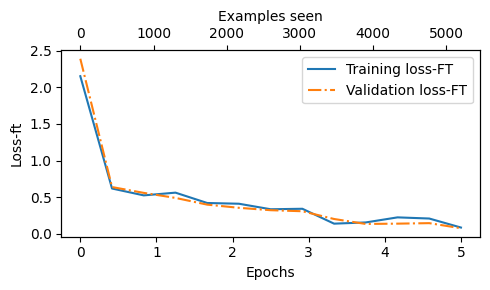

In [62]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

<div class="alert alert-block alert-info">
    
As we can see based on the sharp downward slope, the model is learning well
from the training data, and there is little to no indication of overfitting; that is, there is no
noticeable gap between the training and validation set losses).

</div>

<div class="alert alert-block alert-success">

Using the same plot_values function, let's now also plot the classification accuracies:

</div>

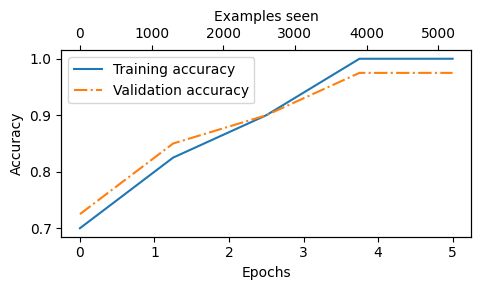

In [63]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

<div class="alert alert-block alert-info">
    
Based on the accuracy plot, the model achieves a relatively high training and
validation accuracy after epochs 4 and 5.
    
However, it's important to note that we previously set eval_iter=5 when using the
train_classifier_simple function, which means our estimations of training and
validation performance were based on only 5 batches for efficiency during training.

Now, we will calculate the performance metrics for the training, validation, and test sets
across the entire dataset by running the following code, this time without defining the
eval_iter value:

</div>

In [64]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy:- {train_accuracy*100:.2f}%")
print(f"Validation accuracy:- {val_accuracy*100:.2f}%")
print(f"Test accuracy:- {test_accuracy*100:.2f}%")

Training accuracy:- 97.21%
Validation accuracy:- 97.32%
Test accuracy:- 95.67%


<div class="alert alert-block alert-warning">

The training and test set performances are almost identical.

A slight discrepancy between the training and test set accuracies suggests minimal
overfitting of the training data. 

Typically, the validation set accuracy is somewhat higher
than the test set accuracy because the model development often involves tuning
hyperparameters to perform well on the validation set, which might not generalize as
effectively to the test set.

This situation is common, but the gap could potentially be minimized by adjusting the
model's settings, such as increasing the dropout rate (drop_rate) or the weight_decay
parameter in the optimizer configuration.

</div>

## USING THE LLM AS A SPAM CLASSIFIER

<div class="alert alert-block alert-success">

After finetuning and evaluating the model in the previous sections, we are now in the final
stage of this proccess/section:  using the model to classify spam
messages.
</div>

<div class="alert alert-block alert-success">

Finally, let's use the finetuned GPT-based spam classification model. 

The following
classify_review function follows data preprocessing steps similar to those we used in the
SpamDataset implemented earlier. 

And then, after processing text into token
IDs, the function uses the model to predict an integer class label, similar to what we have
implemented earlier, and then returns the corresponding class name:
</div>

<div class="alert alert-block alert-info">
    
Step 1: Prepare inputs to the model

Step 2: Truncate sequences if they too long
    
Step 3: Pad sequences to the longest sequence

Step 4: Add batch dimension

Step 5: Model inference without gradient tracking
    
Step 6: Logits of the last output token

Step 7: Return the classified result

</div>

In [65]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

<div class="alert alert-block alert-success">

Let's try this classify_review function on an example text:
</div>

In [66]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


<div class="alert alert-block alert-info">
    
The resulting model correctly predicts "spam".
</div>

In [67]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


<div class="alert alert-block alert-info">
    
Also, here, the model makes a correct prediction and returns a "not spam" label.
</div>

<div class="alert alert-block alert-success">

Finally, let's save the model in case we want to reuse the model later without having to
train it again using the torch.save method
</div>

In [68]:
torch.save(model.state_dict(), "review_classifier.pth")

<div class="alert alert-block alert-success">

Once saved, the model can be loaded as follows:
</div>

In [69]:
model_state_dict = torch.load("review_classifier.pth")
model.load_state_dict(model_state_dict)

<All keys matched successfully>

# INSTRUCTION FINE-TUNING

## STEP 1: PREPARING DATASET

<div class="alert alert-block alert-success">

In this section, we download and format the instruction dataset for instruction finetuning a
pretrained LLM in this section. The dataset consists of 1100 instruction-response pairs.

The following code implements and executes a function to download this dataset, which
is a relatively small file, only 204 KB in size, in JSON format. JSON, or JavaScript Object
Notation, mirrors the structure of Python dictionaries, providing a simple structure for data
interchange that is both human-readable and machine-friendly.

</div>

In [53]:
import json
import os
import urllib
import ssl

def download_and_load_file(file_path, url):
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url, context=ssl_context) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data

file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:-", len(data))

Number of entries:- 1100


<div class="alert alert-block alert-success">

The data list , which we loaded from the JSON file contains the 1100 entries of the
instruction dataset. 

Let's print one of the entries to see how each entry is structured:

</div>

In [54]:
print("Example entry:-\n", data[50])

Example entry:-
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [55]:
print("Another example entry:-\n", data[999])

Another example entry:-
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


### CONVERTING INSTRUCTIONS INTO ALPACA FORMAT

In [56]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

<div class="alert alert-block alert-info">
    
This format_input function takes a dictionary entry as input and constructs a formatted
string.

</div>

<div class="alert alert-block alert-success">

 Let's test it to dataset entry data[50], which we looked at earlier:

</div>

In [57]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


<div class="alert alert-block alert-warning">

Note that the format_input skips the optional ### Input: section if the 'input' field is
empty, which we can test out by applying the format_input function to entry data[999]
that we inspected earlier:

</div>

In [58]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


### SPLITTING DATASET INTO TRAIN-TEST-VALIDATION

In [59]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [60]:
print("Training set length:-", len(train_data))
print("Validation set length:-", len(val_data))
print("Test set length:-", len(test_data))

Training set length:- 935
Validation set length:- 55
Test set length:- 110


<div class="alert alert-block alert-warning">

Having successfully downloaded and partitioned the dataset, and gained a clear
understanding of the dataset prompt formatting, we are now ready for the core
implementation of the instruction finetuning process.

</div>

## STEP 2: ORGANIZING DATA INTO TRAINING BATCHES

<div class="alert alert-block alert-success">

In the previous section, the training batches were created automatically by the PyTorch
DataLoader class, which employs a default collate function to combine lists of samples into
batches. 

A collate function is responsible for taking a list of individual data samples and
merging them into a single batch that can be processed efficiently by the model during
training.

</div>

<div class="alert alert-block alert-warning">

However, the batching process for instruction finetuning in this section is a bit more
involved and requires us to create our own custom collate function that we will later plug
into the DataLoader. 

We implement this custom collate function to handle the specific
requirements and formatting of our instruction finetuning dataset.

</div>

<div class="alert alert-block alert-success">

First, we code an
InstructionDataset class that applies format_input from the previous section and pretokenizes all inputs in the dataset, similar to the SpamDataset which we saw earlier.

</div>

In [61]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

<div class="alert alert-block alert-warning">

Similar to the approach we saw earlier in previous sections, we aim to accelerate training by collecting multiple
training examples in a batch, which necessitates padding all inputs to a similar length. 

As with the previous section, we use the <|endoftext|> token as a padding token.
    
Instead of appending the <|endoftext|> tokens to the text inputs, we can append its
token ID to the pre-tokenized inputs directly. 

To remind us which token ID we should use,
we can use the tokenizer's .encode method on an <|endoftext|> token:

</div>

In [62]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


<div class="alert alert-block alert-warning">

In previous sections, we padded all examples in a dataset to the same length. 

Moving on, here, we adopt a more sophisticated approach by developing a custom
collate function that we can pass to the data loader. 

This custom collate function pads the
training examples in each batch to have the same length, while allowing different batches
to have different lengths.

This approach minimizes unnecessary
padding by only extending sequences to match the longest one in each batch, not the
whole dataset.

</div>

<div class="alert alert-block alert-success">

We can implement the padding process with a custom collate
function as follows:
</div>

<div class="alert alert-block alert-info">
    
Step 1: Find the longest sequence in the batch
    
Step 2: Pad and prepare inputs
    
Step 3: Remove extra padded token added earlier

Step 4: Convert list of inputs to tensor and transfer to target device

</div>

In [63]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

<div class="alert alert-block alert-info">
    
The custom_collate_draft_1 we implemented is designed to be integrated into a PyTorch
DataLoader, but it can also function as a standalone tool. 

Here, we use it independently to
test and verify that it operates as intended. 

</div>

<div class="alert alert-block alert-success">

Let's try it on three different inputs that we
want to assemble into a batch, where each example gets padded to the same length:

</div>

In [64]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


<div class="alert alert-block alert-info">
    
As we can see based on the preceding output, all inputs have been padded to the length of
the longest input list, inputs_1 containing 5 token IDs.

</div>

<div class="alert alert-block alert-warning">

So far, we have just implemented our first custom collate function to create batches from
lists of inputs. 

However, as we learned in previous lessons/section, we also need to create batches
with the target token IDs, corresponding to the batch of input IDs. 

These target IDs are crucial because they represent what we want the model to
generate and what we need during training to calculate the loss for the weight updates,
similar to previous chapters.

</div>

#### CREATING TARGET TOKEN IDS FOR TRAINING

<div class="alert alert-block alert-success">

Similar to the process described for pretraining an LLM, the target token IDs
match the input token IDs but are shifted one position to the right. 

This setup allows the LLM to learn how to predict the next token in a sequence.

</div>

<div class="alert alert-block alert-success">

The following updated collate function generates the target token IDs from the input token IDs:

</div>

In [65]:
def custom_collate_draft_2(
        batch,
        pad_token_id=50256,
        device="cpu"
):
    # Find the longest sequence in the batch 
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    input_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1]) # Truncate the last token for inputs
        targets = torch.tensor(padded[1:]) # Shift +1 to the right for targets
        input_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device 
    inputs_tensor = torch.stack(input_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

<div class="alert alert-block alert-info">
    
Step 1: Truncate the last token for inputs
                               
Step 2: Shift +1 to the right for targets

</div>

In [66]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)


tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


<div class="alert alert-block alert-info">
    
The 1st tensor represents inputs.
    
The 2nd tensor represents the targets

</div>

<div class="alert alert-block alert-success">

In the next step, we assign a -100 placeholder value to all padding tokens.

This special value allows us to exclude these padding tokens from contributing to
the training loss calculation, ensuring that only meaningful data influences model learning.

In classification fine-tuning, we did not have to worry about this since we only trained the model based on
the last output token.
</div>

<div class="alert alert-block alert-warning">

Note that we retain one end-of-text token, ID 50256, in the target list.

This allows the LLM to learn when to generate an end-of-text token
in response to instructions, which we use as an indicator that the generated response is
complete.

</div>

<div class="alert alert-block alert-success">

In the following code, we modify our custom collate function to replace tokens with ID
50256 with -100 in the target lists.

Additionally, we introduce
an allowed_max_length parameter to optionally limit the length of the samples. 

This
adjustment will be useful if you plan to work with your own datasets that exceed the 1024-
token context size supported by the GPT-2 model. 

The code for this updated collate function
is as follows:
</div>

In [67]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

<div class="alert alert-block alert-info">
    
Step 1: Replace all but the first padding tokens in targets by ignore_index

Step 2: Optionally truncate to maximum sequence length

</div>

<div class="alert alert-block alert-success">

Again, let's try the collate function on the sample batch that we created earlier to check
that it works as intended:
</div>

In [68]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


<div class="alert alert-block alert-info">
    
The modified collate function works as expected, altering the target list by inserting the
token ID -100. 

What is the logic behind this adjustment? Let's explore the underlying
purpose of this modification.

</div>

<div class="alert alert-block alert-warning">

For demonstration purposes, consider the following simple and self-contained example
where each output logit can correspond to a potential token from the model's vocabulary.

Here's how we might calculate the cross entropy loss (introduced earlier) during
training when the model predicts a sequence of tokens, similar to what we have done in sections when pretraining the model, or when finetuning the model for
classification:

</div>

In [69]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])

loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


<div class="alert alert-block alert-success">

Adding an additional token ID will, as we would expect, affect the loss calculation.
</div>

In [70]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


<div class="alert alert-block alert-success">

Now, let's get to the interesting part and see what happens if we replace the third target
token ID with -100:
</div>

In [71]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:-", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3:- tensor(True)


<div class="alert alert-block alert-warning">

Based on this result, we can see that the resulting loss on these 3 training examples is
identical to the loss we calculated from the 2 training examples earlier. 

In other words, the
cross entropy loss function ignored the third entry in the targets_3 vector, the token ID
corresponding to -100. 

(Interested readers can try to replace the -100 value with another
token IDs that is not 0 or 1, and will see that this results in an error.)

</div>

<div class="alert alert-block alert-warning">

So, what's so special about -100 that it's ignored by the cross entropy loss? The default
setting of the cross entropy function in PyTorch is cross_entropy(...,
ignore_index=-100). 

This means that it ignores targets labeled with -100.

</div>

<div class="alert alert-block alert-warning">

In this section, we take advantage of this ignore_index to ignore the additional end-of-text (padding) tokens that we used to pad the training examples to have the same length in
each batch.

</div>

<div class="alert alert-block alert-warning">

However, we want to keep one 50256 (end-of-text)
token ID in the targets because it helps the LLM to learn to generate end-of-text tokens,
which we can use as an indicator that a response is complete.

</div>

#### MASKING TARGET TOKEN IDS

<div class="alert alert-block alert-info">
    
In addition to masking out padding tokens, it is also common to mask out the target
token IDs that correspond to the instruction

</div>

<div class="alert alert-block alert-success">

By masking out the target token IDs that correspond to the instruction, the LLM cross entropy loss is only computed for the generated response target
IDs. 

By masking out the instruction tokens, the model is trained to focus on generating
accurate responses rather than additionally also memorizing instructions, which can help
with reducing overfitting.
</div>

<div class="alert alert-block alert-info">
    
Currently, researchers are divided on whether masking the instructions is universally beneficial during instruction finetuning. 

For instance, a recent
paper titled "Instruction Tuning With Loss Over Instructions" demonstrated that not
masking the instructions benefits the LLM performance.

In this part, we do not apply masking and leave it as an optional
exercise for further study/research.

</div>

## STEP 3: CREATING DATALOADERS FROM AN INSTRUCTION DATASET

<div class="alert alert-block alert-warning">

The custom_collate_fn includes code to move the input and target tensors (for
example, torch.stack(inputs_lst).to(device)) to a specified device, which can be
either "cpu" or "cuda" (for GPUs), or optionally "mps" for Macs with Apple Silicon chips.

</div>

<div class="alert alert-block alert-warning">

In previous sections, we moved the data onto the target device (for example, the GPU
memory when device="cuda") in the main training loop. Having this as part of the collate
function offers the advantage of performing this device transfer process as a background
process outside the training loop, preventing it from blocking the GPU during model
training.

</div>

<div class="alert alert-block alert-success">

The following code initializes the device variable:
</div>

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is much faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")

print("Device:-", device)

Device:- cpu


<div class="alert alert-block alert-success">

Next, to reuse the chosen device setting in custom_collate_fn when we plug it into the
PyTorch DataLoader class later in this section, we use the partial function from Python's
functools standard library to create a new version of the function with the device
argument pre-filled. 

Additionally, we set the allowed_max_length to 1024, which truncates
the data to the maximum context length supported by the GPT-2 model we finetune later in
this section:
</div>

In [73]:
from functools import partial 
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

<div class="alert alert-block alert-success">

Next, we can set up the data loaders as we did in previous sections, but this time we will
use our custom collate function for the batching process:
</div>

In [74]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

<div class="alert alert-block alert-success">

Let's examine the dimensions of the input and target batches generated by the training
loader:
</div>

In [75]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

torch.Size([8, 64]) torch.Size([8, 64])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 89]) torch.Size([8, 89])
torch.Size([8, 59]) torch.Size([8, 59])
torch.Size([8, 88]) torch.Size([8, 88])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 60]) torch.Size([8, 60])
torch.Size([8, 60]) torch.Size([8, 60])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 58]) torch.Size([8, 58])
torch.Size([8, 71]) torch.Size([8, 71])


<div class="alert alert-block alert-info">
    
In the preceding output, we can see that the first input and target batch have dimensions
8×61, where 8 represents the batch size, and 61 is the number of tokens in each training
example in this batch. 

The second input and target batch have a different number of
tokens, for instance, 76.


As we saw in the preceding code output, thanks to our custom collate function, the data
loader is able to create batches of different lengths. 

In the next section, we load a
pretrained LLM that we can then finetune with this data loader.

</div>